#### *Goal*
Build model to predict taxi trip time.
We will be using NYC For Hire Taxi trip records. 

[Data can be found here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from typing import List, Dict, Optional

from utils.download_parquet import download_parquet
import os
import pathlib
import glob

pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-trips")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-trips', tags={}>

In [3]:
sns.set_style("white")

In [4]:
fhvhv_columns=[
'hvfhs_license_num',
'pickup_datetime',
'dropoff_datetime', 
'PULocationID', 
'DOLocationID', 
'trip_miles',
'trip_time', 
'tips']

green_columns = [
    'VendorID', 
    'lpep_pickup_datetime',
    'lpep_dropoff_datetime',
    'PULocationID', 
    'DOLocationID',
    'trip_distance',
    'trip_type']

In [12]:
months = list(pd.period_range(start="2019-01-01", end="2019-12-01", freq="M").astype(str))

In [15]:
def download_data(months: List, taxi_type: str, directory: str) -> None:
    print(f"Downloading {taxi_type} trip data from {months[0]} to {months[-1]}")
    for ym in months:
        download_parquet(
            year_month=ym, 
            taxi_type="green", 
            directory="data")
    print("Done!")

In [16]:
taxi_type = "green"

training_months = list(pd.period_range(
    start="2019-01-01", 
    end="2019-12-01", 
    freq="M").astype(str))

validation_months = list(pd.period_range(
    start="2021-01-01", 
    end="2021-12-01", 
    freq="M").astype(str))

testing_months = list(pd.period_range(
    start="2022-01-01", 
    end="2022-03-01", 
    freq="M").astype(str))

In [17]:
path = pathlib.Path.cwd() / "data" / f"{taxi_type}"

In [18]:
training_files = [f for f in path.iterdir() if f.stem.split("_")[-1] in training_months]
validation_files = [f for f in path.iterdir() if f.stem.split("_")[-1] in validation_months]
testing_files = [f for f in path.iterdir() if f.stem.split("_")[-1] in testing_months]

In [19]:
training_data = pd.read_parquet(
    training_files,
    engine="pyarrow",
    columns=green_columns
)

In [20]:
validation_data = pd.read_parquet(
    validation_files,
    engine="pyarrow",
    columns=green_columns
)

In [21]:
testing_data = pd.read_parquet(
    testing_files,
    engine="pyarrow",
    columns=green_columns
)

In [22]:
def calculate_trip_duration(df, pickup_datetime, dropoff_datetime):
   df["trip_duration"] = (df[dropoff_datetime] - df[pickup_datetime]) / pd.Timedelta("1 minute")
   return df


def fill_missing_values(df, columns, replace_missing=-1):
   df[columns] = df[columns].fillna(replace_missing)
   return df

- Convert dates to timestamp (had issue with parsing parquet with out of bound timestamp so had to convert to string)
- Calculate sin/cos of hour of trip 
- Convert appropriate features to categorical
- Calculate trip duration (minutes)

Keep records within band of:
- trip_duration >= 1 min 
- trip_duration <= 60 min

In [26]:
def prep_green_taxi_data(df):
    return (df
            .assign(
                trip_route = df["PULocationID"].astype(str) + "_" + df["DOLocationID"].astype(str),
            )
            .assign(
                **{c:lambda df_, c=c:pd.to_datetime(df_[c], unit="ns", errors="coerce") for c in ["lpep_pickup_datetime","lpep_dropoff_datetime"]},
                day_of_week = lambda df_: df_["lpep_pickup_datetime"].dt.day_name().astype("category"),
                hour_of_day = lambda df_: df_["lpep_pickup_datetime"].dt.hour.astype("category"),
                hour_of_day_sin = lambda df_: np.sin(df_["lpep_pickup_datetime"].dt.hour*(2*np.pi/24)),
                hour_of_day_cos = lambda df_: np.cos(df_["lpep_pickup_datetime"].dt.hour*(2*np.pi/24)),
            )
            .pipe(calculate_trip_duration, "lpep_pickup_datetime","lpep_dropoff_datetime")
            .pipe(fill_missing_values, ["PULocationID","DOLocationID","VendorID","trip_type"])
            .assign(
                **{c:lambda df_, c=c:df_[c].astype("category") for c in ["PULocationID","DOLocationID","VendorID","trip_route","trip_type"]} 
            )
            .query("trip_duration >=1 and trip_duration <= 60")
          
           

    )

In [27]:
def prep_fhvhv_taxi_data(df):
    return (df
            .assign(
                trip_route = df["PULocationID"].astype(str) + "_" + df["DOLocationID"].astype(str),
                trip_time = df["trip_time"]/60
            )
            .assign(
                **{c:lambda df_, c=c:pd.to_datetime(df_[c], unit="ns", errors="coerce") for c in ["pickup_datetime","dropoff_datetime"]},
                day_of_week = lambda df_: df_["pickup_datetime"].dt.day_name().astype("category"),
                hour_of_day = lambda df_: df_["pickup_datetime"].dt.hour.astype("category"),
                hour_of_day_sin = lambda df_: np.sin(df_["pickup_datetime"].dt.hour*(2*np.pi/24)),
                hour_of_day_cos = lambda df_: np.cos(df_["pickup_datetime"].dt.hour*(2*np.pi/24)),
                **{c:lambda df_, c=c:df_[c].astype("category") for c in ["PULocationID","DOLocationID","hvfhs_license_num","trip_route"]} 
            )
            .query("trip_time >=1 and trip_time <= 60")
          
           

    )

In [28]:
training_data = prep_green_taxi_data(training_data)
validation_data = prep_green_taxi_data(validation_data)
testing_data = prep_green_taxi_data(testing_data)

In [38]:
validation_data.query("trip_duration>60")

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,trip_type,trip_route,day_of_week,hour_of_day,hour_of_day_sin,hour_of_day_cos,trip_duration


In [40]:
def preprocess(
    data: pd.DataFrame, 
    features: List,
    dv: DictVectorizer,
    fit_dv: bool = False) -> (List, DictVectorizer):
    
    dicts = data[features].to_dict(orient="records")
    
    if fit_dv:
        X = dv.fit_transform(dicts)
    else:
        X = dv.transform(dicts)
    return X, dv
    
    

In [30]:
features = [
    'VendorID',
    'PULocationID',
    'DOLocationID', 
    'trip_distance',
    'trip_type', 
    'trip_route',
    'day_of_week',
    'hour_of_day']

target = 'trip_duration'

dv = DictVectorizer()

In [31]:
X_train, dv = preprocess(training_data, features, dv, fit_dv=True)
X_val, _ = preprocess(validation_data, features, dv, fit_dv=False)
X_test, _ = preprocess(testing_data, features, dv, fit_dv=False)

y_train = training_data[target].values
y_val = validation_data[target].values
y_test = testing_data[target].values

In [41]:
def fit_model(model, X_train: List, y_train: List, X_val: List) -> List:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    return y_pred

In [42]:
y_pred_lr = fit_model(LinearRegression(), X_train, y_train, X_val)

In [51]:
features = [
    'VendorID',
    'PULocationID',
    'DOLocationID', 
    'trip_distance',
    'trip_type', 
    'trip_route',
    'day_of_week',
    'hour_of_day_sin',
    'hour_of_day_cos']

target = 'trip_duration'

dv = DictVectorizer()

#

X_train, dv = preprocess(training_data, features, dv, fit_dv=True)
X_val, _ = preprocess(validation_data, features, dv, fit_dv=False)
X_test, _ = preprocess(testing_data, features, dv, fit_dv=False)

y_train = training_data[target].values
y_val = validation_data[target].values
y_test = testing_data[target].values

In [53]:
y_pred_lr2 = fit_model(LinearRegression(), X_train, y_train, X_val)

In [54]:
rmse = mean_squared_error(y_val, y_pred_lr, squared=False)
print(f"Our model is incorrect on average by {round(rmse,3)} minutes")

Our model is incorrect on average by 13.35 minutes


In [55]:
rmse = mean_squared_error(y_val, y_pred_lr2, squared=False)
print(f"Our model is incorrect on average by {round(rmse,3)} minutes")

Our model is incorrect on average by 13.284 minutes


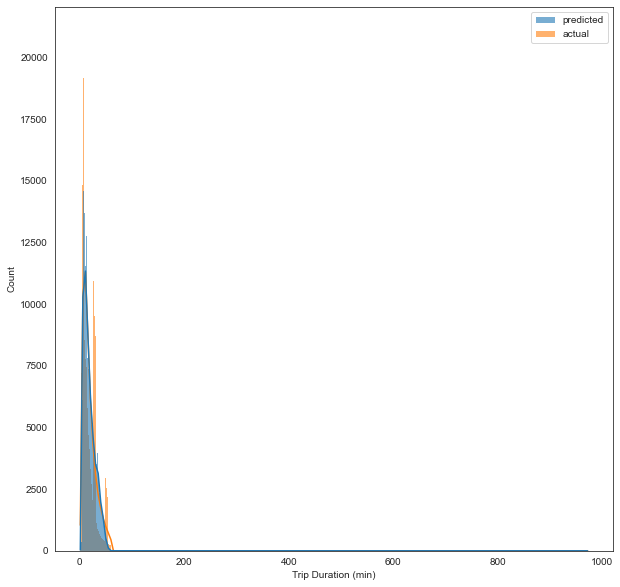

In [39]:
data = {"predicted": y_pred, "actual": y_val}
ax = sns.histplot(data, kde=True, alpha=0.6)
ax.set(xlabel="Trip Duration (min)")
ax.figure.set_size_inches(10, 10)

Lasso

Getting more creative with our features we train our model with

In [51]:
def prep_dataset(df, categorical, numerical, target):
    print(f"Original data has {df.shape[0]} records.")

    df["trip_duration"] = calculate_trip_duration(df, "pickup_datetime", "dropOff_datetime")
    df["PUlocationID"] = df["PUlocationID"].fillna(-1)
    df["DOlocationID"] = df["DOlocationID"].fillna(-1)


    df["trip_route"] = df["PUlocationID"].astype(str) + "_" + df["DOlocationID"].astype(str)
    df["day_of_week"] = df["pickup_datetime"].dt.day_name()
    df["hour_of_day"] = df["pickup_datetime"].dt.hour

    df = df.loc[(df["trip_duration"]>=1) & (df["trip_duration"]<=60)].copy()

    if categorical:
        df[categorical] = df[categorical].astype(str)
    if numerical:
        df[numerical] = df[numerical].astype(float)

    print(f"Final data has {df.shape[0]} records.")

    return df

In [52]:
categorical = ["PUlocationID","DOlocationID", "trip_route","hour_of_day"]
numerical = None
target=["trip_duration"]

In [53]:
df_train = prep_dataset(
    df=download_parquet_to_df(year_month="2021-01", taxi_type="fhv"),
    categorical= categorical,
    numerical = numerical,
    target= target)

Original data has 1154112 records.
Final data has 1109826 records.


In [54]:
df_val= prep_dataset(
    df=download_parquet_to_df(year_month="2021-02", taxi_type="fhv"),
    categorical= categorical,
    numerical = numerical,
    target= target)

Original data has 1037692 records.
Final data has 990113 records.


In [55]:
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient="records")
val_dicts = df_val[categorical].to_dict(orient="records")


X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

y_train = df_train[target].values
y_val = df_val[target].values

In [56]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Our model is incorrect on average by {round(mse,3)} minutes")

Our model is incorrect on average by 10.504 minutes


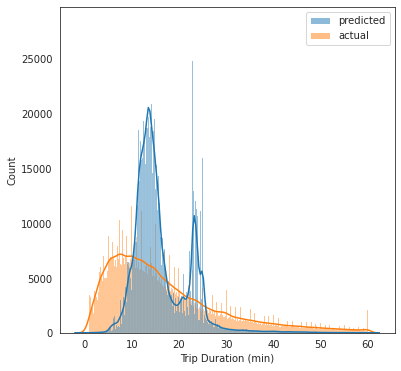

In [57]:
data = {"predicted": y_pred.squeeze(), "actual": y_val.squeeze()}
ax = sns.histplot(data, kde=True, alpha=0.5)
ax.set(xlabel="Trip Duration (min)")
ax.figure.set_size_inches(6, 6)